In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t, ttest_ind

### Mails sent

In [2]:
names = ['customernumber', 'group', 'series', 'maildate']
mails = pd.read_excel('eval OOC triggers mail.xlsx', sheetname=2, names=names)
print len(mails)
mails.tail()

201


,customernumber,group,series,maildate
196,264411488,test,Ordinary Lies,2017-04-27
197,592780033,test,Ordinary Lies,2017-04-27
198,663266802,test,Ordinary Lies,2017-04-27
199,671609509,test,Ordinary Lies,2017-04-27
200,683208786,test,Ordinary Lies,2017-04-27


### Viewing behavior

In [3]:
behavior = pd.read_excel('eval OOC triggers mail.xlsx', sheetname=3, headers=None)
print len(behavior)
behavior.tail()

3235


,customernumber,timestamp,datum,groep,programcrid,programseriesname
3230,1020652992,1491138177000,2017-04-02 14:02:57,test,crid://telenet.be/AA/TN00037209_01_0012-OSNL-SD,Black-ish
3231,1020652992,1491139427000,2017-04-02 14:23:47,test,crid://telenet.be/AA/TN00037209_01_0013-OSNL-SD,Black-ish
3232,1020652992,1491130190000,2017-04-02 11:49:50,test,crid://telenet.be/AA/TN00037209_01_0006-OSNL-SD,Black-ish
3233,1020652992,1491133171000,2017-04-02 12:39:31,test,crid://telenet.be/AA/TN00037209_01_0008-OSNL-SD,Black-ish
3234,1020652992,1491134421000,2017-04-02 13:00:21,test,crid://telenet.be/AA/TN00037209_01_0009-OSNL-SD,Black-ish


### Merged data

In [4]:
data = pd.merge(mails, behavior, on='customernumber')
data = data[data.series == data.programseriesname]
print len(data)
data.sort_values('datum', ascending=False).head()

3218


,customernumber,group,series,maildate,timestamp,datum,groep,programcrid,programseriesname
1739,222178496,test,Black-ish,2017-04-21,1492990836000,2017-04-24 00:40:36,test,crid://telenet.be/AA/TN00037209_02_0019-OSNL-SD,Black-ish
1743,222178496,test,Black-ish,2017-04-21,1492989578000,2017-04-24 00:19:38,test,crid://telenet.be/AA/TN00037209_02_0018-OSNL-SD,Black-ish
2876,618346809,test,Black-ish,2017-04-27,1492988273000,2017-04-23 23:57:53,-,crid://telenet.be/AA/TN00037209_01_0016-OSNL-SD,Black-ish
1741,222178496,test,Black-ish,2017-04-21,1492988194000,2017-04-23 23:56:34,test,crid://telenet.be/AA/TN00037209_02_0017-OSNL-SD,Black-ish
2879,618346809,test,Black-ish,2017-04-27,1492987346000,2017-04-23 23:42:26,-,crid://telenet.be/AA/TN00037209_01_0015-OSNL-SD,Black-ish


### Get number of series, grouped by customer, group and pre/post trigger

Viewings splitted pre and post trigger

In [5]:
pre = data[(data.maildate - data.datum) > pd.Timedelta(0)]
post = data[(data.maildate - data.datum) <= pd.Timedelta(0)]

Number of viewings grouped per customer

In [6]:
pre = pre.groupby(['customernumber']).agg({'group':'min', 'customernumber':'count'})
post = post.groupby(['customernumber']).agg({'group':'min', 'customernumber':'count'})

Centralize to include zero counts

In [7]:
counts = pd.merge(pre, post, left_index=True, right_index=True, how='outer').fillna(0)
counts.drop('group_y', 1, inplace=True)
counts.columns=['group', 'pre', 'post']
counts.head(10)

,group,pre,post
customernumber,,,
3070553,test,24,0.0
5748056,test,28,0.0
8823360,test,6,0.0
10664542,test,34,4.0
12230585,test,13,0.0
13607581,control,6,0.0
14710250,test,8,4.0
15678735,test,5,0.0
16645503,test,6,0.0


In [8]:
pretest = counts[counts.group=='test'].pre
precontrol = counts[counts.group=='control'].pre
posttest = counts[counts.group=='test'].post
postcontrol = counts[counts.group=='control'].post

Check

In [9]:
(sum(pretest) + sum(precontrol) + sum(postcontrol) + sum(posttest) == len(data))

True

### Pre trigger
T-test between test & control should fail to reject null hypothesis as neither received mails.

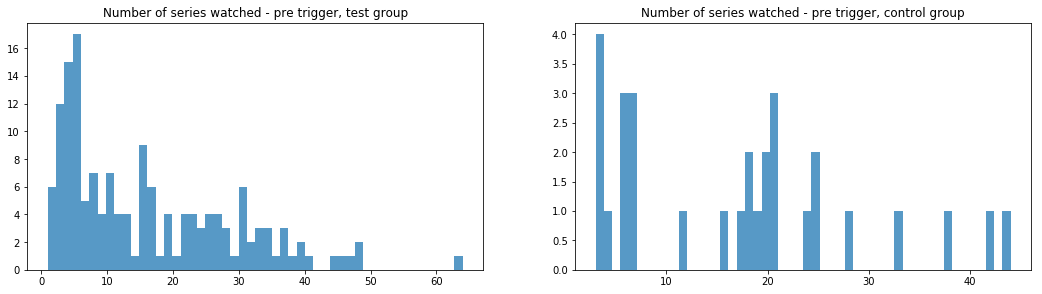

In [10]:
x = np.linspace(0,1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.hist(pretest, bins=50, alpha=0.75)
ax2.hist(precontrol, bins=50, alpha=0.75)
ax1.set_title('Number of series watched - pre trigger, test group')
ax2.set_title('Number of series watched - pre trigger, control group')
plt.show()

In [11]:
tMu, cMu = pretest.mean(), precontrol.mean()
tSd, cSd = np.std(pretest), np.std(precontrol)
tN, cN = len(pretest), len(precontrol)

In [12]:
M = tMu - cMu
S = np.sqrt(((tN - 1) * np.power(tSd, 2) + (cN - 1) * np.power(cSd, 2)) / (tN + cN - 2) * (1/float(tN) + 1/float(cN)))
T = M / S
Tcritical = t.ppf(.975, tN + cN - 2)
print T, Tcritical, T > Tcritical

-0.395978993285 1.97308407733 False


Fail to reject H0.

### Post trigger
T-test between test & control might reject null hypothesis as test group received mails.

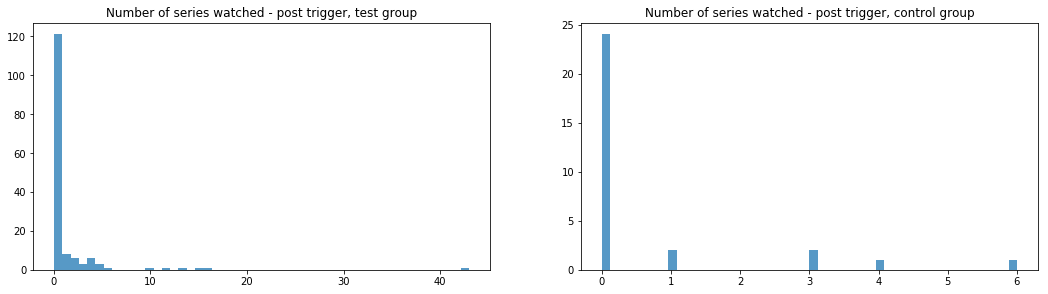

In [13]:
x = np.linspace(0,1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax1.hist(posttest, bins=50, alpha=0.75)
ax2.hist(postcontrol, bins=50, alpha=0.75)
ax1.set_title('Number of series watched - post trigger, test group')
ax2.set_title('Number of series watched - post trigger, control group')
plt.show()

In [14]:
tMu, cMu = posttest.mean(), postcontrol.mean()
tSd, cSd = np.std(posttest), np.std(postcontrol)
tN, cN = len(posttest), len(postcontrol)

In [15]:
M = tMu - cMu
S = np.sqrt(((tN - 1) * np.power(tSd, 2) + (cN - 1) * np.power(cSd, 2)) / (tN + cN - 2) * (1/float(tN) + 1/float(cN)))
T = M / S
Tcritical = t.ppf(.975, tN + cN - 2)
print T, Tcritical, T > Tcritical

0.747248000638 1.97308407733 False


Fail to reject H0.

### Conclusion

Pretest vs Precontrol, not significantly different.

In [16]:
print ttest_ind(pretest, precontrol)
print 'Critical T value:', t.ppf(.975, len(pretest) + len(precontrol) - 2)

Ttest_indResult(statistic=-0.39395455950569325, pvalue=0.6940757679265992)
Critical T value: 1.97308407733


Posttest vs Postcontrol, not significantly different

In [17]:
print ttest_ind(posttest, postcontrol)
print 'Critical T value:', t.ppf(.975, len(posttest) + len(postcontrol) - 2)

Ttest_indResult(statistic=0.74460205479347241, pvalue=0.45747268901458349)
Critical T value: 1.97308407733


Pretest vs Posttest, significantly different

In [18]:
print ttest_ind(pretest, posttest)
print 'Critical T value:', t.ppf(.975, len(pretest) + len(posttest) - 2)

Ttest_indResult(statistic=13.76508671097468, pvalue=6.9488040203483256e-34)
Critical T value: 1.96774673759


Precontrol vs Postcontrol, significantly different

In [19]:
print ttest_ind(precontrol, postcontrol)
print 'Critical T value:', t.ppf(.975, len(precontrol) + len(postcontrol) - 2)

Ttest_indResult(statistic=7.6410857507496983, pvalue=2.4518587774207616e-10)
Critical T value: 2.00171748301
